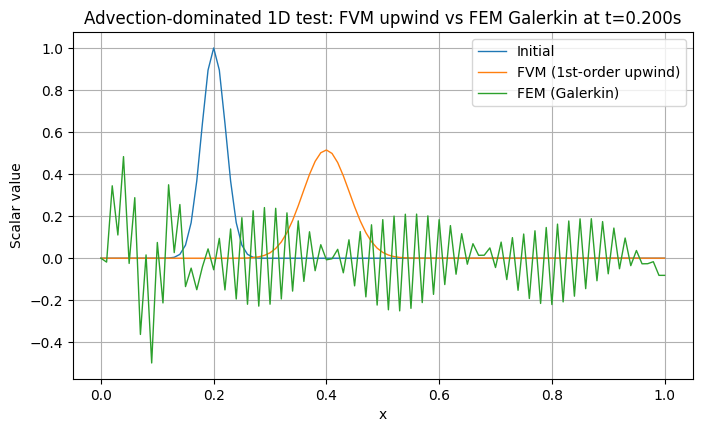

In [4]:
# Retry simplified run with smaller final time for speed and reliability.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import solve

# Domain and parameters (smaller for speed)
L = 1.0
nx = 101
x = np.linspace(0, L, nx)
dx = x[1] - x[0]

u = 1.0        # advection velocity
nu = 1e-4      # diffusion coefficient (small -> advection-dominated)
t_final = 0.2   # shorter time to reduce work
CFL = 0.4      # for explicit time stepping stability (for FVM)
dt = CFL * dx / u
nt = int(np.ceil(t_final / dt))
dt = t_final / nt  # adjust to hit final time exactly

# Initial condition: Gaussian pulse near left
def initial(x):
    return np.exp(-((x-0.2)/0.03)**2)

u0 = initial(x)

# --- Finite Volume (first-order upwind + explicit diffusion) ---
phi_fvm = u0.copy()
for n in range(nt):
    phi_old = phi_fvm.copy()
    adv_flux = np.zeros(nx+1)
    adv_flux[1:-1] = u * phi_old[:-1]
    diff_flux = np.zeros(nx+1)
    diff_flux[1:-1] = -nu * (phi_old[1:] - phi_old[:-1]) / dx
    phi_fvm -= dt/dx * (adv_flux[1:] - adv_flux[:-1])
    phi_fvm -= dt/dx * (diff_flux[1:] - diff_flux[:-1])
    phi_fvm[0] = initial(0)
    phi_fvm[-1] = phi_fvm[-2]

# --- Finite Element (standard Galerkin, linear elements) ---
M = np.zeros((nx, nx))
K = np.zeros((nx, nx))
for i in range(nx-1):
    Me = (dx/6) * np.array([[2,1],[1,2]])
    Ke = (1/dx) * np.array([[1,-1],[-1,1]])
    M[i:i+2,i:i+2] += Me
    K[i:i+2,i:i+2] += Ke

A = np.zeros((nx,nx))
for i in range(nx-1):
    Ae = np.array([[-0.5, -0.5],[0.5,0.5]])
    A[i:i+2,i:i+2] += Ae
A = A / dx

phi_fem = u0.copy()
theta = 0.5
M_mat = M.copy()
K_mat = K.copy() * nu
Adv_mat = A.copy() * u

for n in range(nt):
    LHS = M_mat + theta*dt*(Adv_mat + K_mat)
    RHS = (M_mat - (1-theta)*dt*(Adv_mat + K_mat)).dot(phi_fem)
    LHS[0,:] = 0.0
    LHS[:,0] = 0.0
    LHS[0,0] = 1.0
    RHS[0] = initial(0)
    phi_fem = solve(LHS, RHS)
    phi_fem[-1] = phi_fem[-2]

df = pd.DataFrame({
    'x': x,
    'Initial': u0,
    'FVM_upwind': phi_fvm,
    'FEM_Galerkin': phi_fem
})

# Save and plot
plt.figure(figsize=(8,4.5))
plt.plot(df['x'], df['Initial'], linewidth=1, label='Initial')
plt.plot(df['x'], df['FVM_upwind'], linewidth=1, label='FVM (1st-order upwind)')
plt.plot(df['x'], df['FEM_Galerkin'], linewidth=1, label='FEM (Galerkin)')
plt.xlabel('x')
plt.ylabel('Scalar value')
plt.title('Advection-dominated 1D test: FVM upwind vs FEM Galerkin at t={:.3f}s'.format(t_final))
plt.legend()
plt.grid(True)


